In [25]:
import tensorflow as tf
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.backend as K

#### Define Grad-CAM and Respond-CAM with comparing class index

In [26]:
def grad_cam(cnn_model, data, class_index, cmp_class_index, target_layer_name, dim, scores_symbol=None):
    return x_cam(cnn_model, data, class_index, cmp_class_index, target_layer_name, respond=False,
      scores_symbol=scores_symbol, dim=dim)

def respond_cam(cnn_model, data, class_index, cmp_class_index, target_layer_name, dim, scores_symbol=None):
    return x_cam(cnn_model, data, class_index, cmp_class_index, target_layer_name, respond=True,
      scores_symbol=scores_symbol, dim=dim)

#### Common parts of Grad-CAM and Respond-CAM (x_cam)

In [27]:
def x_cam(cnn_model, data, class_index, cmp_class_index, target_layer_name, respond, dim, scores_symbol = None):

    # Get the score_symbol
    if scores_symbol is None:
        softmax_layer, = [l for l in cnn_model.layers if l.name == 'softmax']
        scores_symbol = softmax_layer.input  # scores_symbol is the input of the softmax_layer, the layer to get the class scores
    class_count = cnn_model.weights[-1].shape.dims[-1].value # i.e. length of the last bias vector

    # Get the predicted class_score and the class_score of the class we want to compare
    class_score = K.sum(K.dot(scores_symbol, K.transpose(K.one_hot([class_index], class_count))))
    cmp_class_score = K.sum(K.dot(scores_symbol, K.transpose(K.one_hot([cmp_class_index], class_count))))  
    diff = abs(class_score - cmp_class_score) # Calculate the difference between the class_score of the two classes

    # Get the output of our target layer
    target_layer = cnn_model.get_layer(target_layer_name)
    
    # Get the feature maps and diff
    with tf.GradientTape() as tape:
        helper_model = tf.keras.Model(inputs = cnn_model.input, 
                                             outputs = [target_layer.output, diff])
        activation, diff = helper_model(data)

    # Compute the gradient of diff with respect to the activation of the target layer
    gradients = tape.gradient(diff, activation)
    
    activation = activation[0]
    gradient = gradients[0]

    # Get the CAM:
    axis = tuple(range(dim))
    if respond:
        weights = np.sum(activation * gradient, axis = axis) \
          / (np.sum(activation + 1e-10, axis = axis))
    else:
        weights = np.mean(gradient, axis = axis)
    cam = np.sum(activation * weights, axis = -1)
    
    return cam

#### Test the Diff-CAM

In [28]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [29]:
def cam_over_image(image, cam):

    # Normalize the CAM 
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    
    # Resize the CAM 
    cam_resized = cv2.resize(cam, (image.shape[1], image.shape[0]))
    
    # Original image
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap = 'gray', interpolation = 'nearest')
    plt.title('Original Image')
    
    # Cam overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray', interpolation = 'nearest')
    plt.imshow(cam_resized, cmap='jet', alpha = 0.5, interpolation = 'nearest') 
    plt.title('CAM Overlay')

    plt.show()

1/1 [==============================] - 0s 52ms/step
3


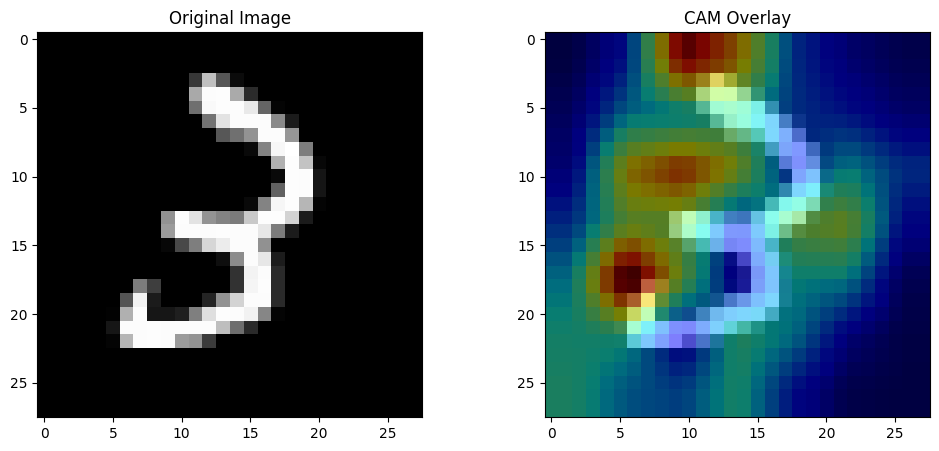

In [30]:
model_test = load_model('model.h5')
image = x_test[63]
cam = respond_cam(model_test, image.reshape(1, 28, 28, 1), 3, 8, 'target_layer', 2, scores_symbol = None)
prediction = model_test.predict(image.reshape(1, 28, 28, 1))
print(np.argmax(prediction))
cam_over_image(image, cam)